In [16]:
import PIL
from PIL import Image
import torch
from torch.autograd import Variable
from torchvision import transforms
import DIW_transforms
import numpy as np 
from models.hourglass import Model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
sz = (320, 240)
model = Model()
model.load_state_dict(torch.load('weights.ckpt', map_location='cpu'))
model.to(device)

Model(
  (seq): Sequential(
    (0): Conv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Channels4(
      (list): ModuleList(
        (0): Sequential(
          (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
          (1): inception[[32], [3, 32, 32], [5, 32, 32], [7, 32, 32]]
          (2): inception[[32], [3, 32, 32], [5, 32, 32], [7, 32, 32]]
          (3): Channels3(
            (list): ModuleList(
              (0): Sequential(
                (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
                (1): inception[[32], [3, 32, 32], [5, 32, 32], [7, 32, 32]]
                (2): inception[[64], [3, 32, 64], [5, 32, 64], [7, 32, 64]]
                (3): Channels2(
                  (list): ModuleList(
                    (0): Sequential(
                      (0): inception[[64], [3, 32, 64], [5, 32, 64], [7, 32, 64]]
               

In [18]:
def batchify(raw_im_array, sz):
    tfms = DIW_transforms.get_tfms(sz)
    batch = []
    
    for im in raw_im_array:
        batch.append(tfms(im))
    
    tensor_batch = torch.stack(batch)
    return Variable(tensor_batch)

def get_pred_depth_maps(preds):
    op_size = preds.size()
    h, w = op_size[2], op_size[3]
    n_pixels = h*w
    depths_batch = preds.data

    depths_batch = depths_batch.view(-1, n_pixels)

    image_wise_min = depths_batch.min(dim=1)[0] 
    image_wise_min = image_wise_min.unsqueeze(dim=1) 
    
    depths_batch = depths_batch - image_wise_min
    
    image_wise_max = depths_batch.max(dim=1)[0]
    image_wise_max = image_wise_max.unsqueeze(dim=1)
    depths_batch = depths_batch / image_wise_max

    depths_batch = depths_batch.view(-1, 1, h, w)
    depths_batch = (depths_batch*255).type(torch.IntTensor)
    depths_batch = depths_batch.squeeze(dim=1).numpy()
    return depths_batch

In [19]:
#image batch would be a numpy array NxHxWx3
im_batch = np.array([np.asarray(Image.open('../IMG_4152.jpg').rotate(180)), np.asarray(Image.open('IMG_4122.jpg').rotate(180))])

def predict(model, im_batch):
    with torch.no_grad():
        model.eval()
        batch = batchify(im_batch, sz)
        batch.to(device)
        preds = model(batch)
        return get_pred_depth_maps(preds)

In [20]:
depths_batch = predict(model, im_batch)

/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:177: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.")
/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


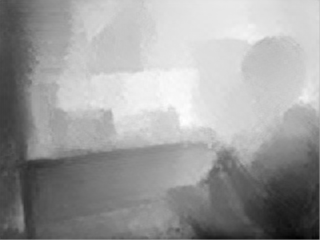

In [21]:
Image.fromarray(depths_batch[0].astype('uint8'))